In [2]:
# System 
import sys, os
import warnings
from tqdm.autonotebook import tqdm
sys.path.append('//Users//KattPaint//Desktop//DATASCI266//Modern-Time-Series-Forecasting-with-Python')
#from src.utils.general import LogTime


# Data Manipulation 
import pandas as pd
import numpy as np 
import math
from datetime import datetime, timedelta

# Visualization 
import matplotlib.pyplot as plt
import plotly.express as px
from itertools import cycle
import plotly.graph_objects as go

# Modeling
from darts.timeseries import TimeSeries
from darts.metrics import mse, mae, mape, rmse
from sklearn.preprocessing import MinMaxScaler
from darts.dataprocessing.transformers import Scaler

# Global Settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.random.seed(42)
tqdm.pandas()

import xgboost as xgb
from darts.models import RegressionModel
from darts.models.forecasting.xgboost import XGBModel
from sklearn.linear_model import Lasso

# Defined Functions 

In [3]:
def format_y_pred(y_pred, name):
    y_pred = y_pred.data_array().to_series()
    y_pred.index = y_pred.index.get_level_values(0)
    y_pred.name = name
    return y_pred

def plot_forecast(pred_df, forecast_columns, forecast_display_names=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns)==len(forecast_display_names)
    mask = ~pred_df[forecast_columns[0]].isnull()
    # colors = ["rgba("+",".join([str(c) for c in plotting_utils.hex_to_rgb(c)])+",<alpha>)" for c in px.colors.qualitative.Plotly]
    colors = [c.replace("rgb", "rgba").replace(")", ", <alpha>)") for c in px.colors.qualitative.Dark2]
    # colors = [c.replace("rgb", "rgba").replace(")", ", <alpha>)") for c in px.colors.qualitative.Safe]
    act_color = colors[0]
    colors = cycle(colors[1:])
    dash_types = cycle(["dash","dot","dashdot"])
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df[mask].act,
                        mode='lines', line = dict(color=act_color.replace("<alpha>", "0.3")),
                        name='Actual 10YT'))
    for col, display_col in zip(forecast_columns,forecast_display_names):
        fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df.loc[mask, col],
                            mode='lines', line = dict(dash=next(dash_types), color=next(colors).replace("<alpha>", "1")),
                            name=display_col))
    return fig

def format_plot(fig, legends = None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=900,
            height=500,
            title_text=title,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

def eval(y_pred, ts_test, horizon=""):
    return {
        "Horizon": horizon,
        "MAE": mae(actual_series = ts_test, pred_series = y_pred),
        "MAPE": mape(actual_series = ts_test, pred_series = y_pred),
        "MSE": mse(actual_series = ts_test, pred_series = y_pred),
        "rMSE": rmse(actual_series = ts_test, pred_series = y_pred)
    }

# Import & Combine Data

In [24]:
data = pd.read_csv('../data/monthly_target_economic_factors.csv')
data = data.rename({'Unnamed: 0':'time_index'}, axis=1)
data = data.set_index('time_index')
data.index = pd.to_datetime(data.index)
data.index.freq = 'MS'

In [42]:
bb = pd.read_csv('../data/final_data.csv')
#bb = bb.drop(['Unnamed: 0'], axis=1)
bb.time_index = pd.to_datetime(bb.time_index)
bb = bb[bb.time_index <= '2024-03-01']

# remove summary data, region-level only 
bb = bb[bb.region != 'su']

# convert scores 
bb.loc[bb.label == "neutral", 'score'] = 0
bb.loc[bb.label == "negative", 'score'] = bb.loc[bb.label == "negative", 'score'] * -1.0

bb_agg = bb.groupby(['time_index', 'region', 'topic']).agg({'score':'mean'}).reset_index()
bb_agg = bb_agg.pivot(index = 'time_index', columns = ['region', 'topic'], values='score')

# create descriptive column names 
names = [col[1] + '_' + col[0] for col in bb_agg.columns]
bb_agg.columns = names
bb_agg = bb_agg[bb_agg.columns.drop(list(bb_agg.filter(regex='none')))]
names = bb_agg.columns

In [43]:
# join data
data_joined = data.join(bb_agg)
data_joined.loc[:, names] = data_joined.loc[:, names].ffill()
data_joined = data_joined.dropna()
data_joined = data_joined.drop(['month'], axis=1)
data_joined.head()

,t10yr,cpi,unemp,ppi,saving,capital_at,consumer_goods_at,credit_at,energy_at,mortgages_at,...,agriculture_mi,capital_mi,mortgages_ri,mortgages_bo,wages_cl,mortgages_kc,mortgages_ny,capital_ny,mortgages_mi,mortgages_cl
time_index,,,,,,,,,,,,,,,,,,,,,
1971-07-01,6.73,0.25,6.00,38.30,13.80,0.78,0.30,0.26,-0.05,-0.97,...,0.85,-0.73,0.94,0.95,0.00,0.93,0.89,-0.05,-0.01,-0.97
1971-08-01,6.58,0.25,6.10,38.50,13.60,0.78,0.31,0.26,-0.05,-0.97,...,-0.83,-0.73,0.94,0.95,0.95,0.93,-0.96,-0.05,0.45,-0.97
1971-09-01,6.14,0.00,6.00,38.30,13.30,0.50,0.24,0.92,0.53,-0.97,...,-0.95,0.00,0.94,0.95,0.95,-0.97,-0.96,0.95,0.94,-0.97
1971-10-01,5.93,0.25,5.80,38.30,13.30,-0.97,-0.01,0.92,0.23,-0.97,...,-0.30,0.00,0.94,-0.88,0.95,-0.97,-0.96,0.95,0.94,-0.97
1971-11-01,5.81,0.00,6.00,38.30,13.10,-0.22,-0.01,0.04,-0.97,0.96,...,0.00,0.00,0.94,-0.88,0.95,0.69,-0.96,-0.45,0.94,-0.97


In [44]:
# convert to timeseries object 
train_ts = TimeSeries.from_dataframe(data_joined)

# split target and covariates 
variables = data_joined.columns 
target = variables[0]
past_covariates = list(variables[1:])

train_targ, train_past_cov = train_ts[target], train_ts[past_covariates]

In [45]:
# initialize scaler 
scaler = MinMaxScaler()
targ_transformer = Scaler(scaler)
cov_transformer = Scaler(scaler)

# fit scaler 
targ_scaler = targ_transformer.fit(train_targ)
cov_scaler = cov_transformer.fit(train_past_cov)

# transform data 
train_targ_sc, train_past_cov_sc = targ_scaler.transform(train_targ), cov_scaler.transform(train_past_cov)

# XGBoost Baseline Modeling 

In [53]:
# create XGBoost model 
xgb_model = RegressionModel(
    model=xgb.XGBRegressor(),
    lags=12, # one seasonal cycle 
    lags_past_covariates=12, # one seasonal cycle 
)

# object to store evaluation metrics 
performance = []

## 1 Month Horizon

In [49]:
start = pd.to_datetime('2010-01-01')

In [50]:
# forecast at each time step 
warnings.filterwarnings('ignore')
startstep1_preds_sc = xgb_model.historical_forecasts(series=train_targ_sc, past_covariates=train_past_cov_sc, forecast_horizon=1, stride=1, start=start)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


In [54]:
# unscale preds 
step1_preds = targ_scaler.inverse_transform(startstep1_preds_sc)

# get actuals for same time period 
step1_act = train_targ[step1_preds.time_index]

# store performance 
metrics = eval(step1_preds, step1_act, "1-month")
performance.append(metrics)

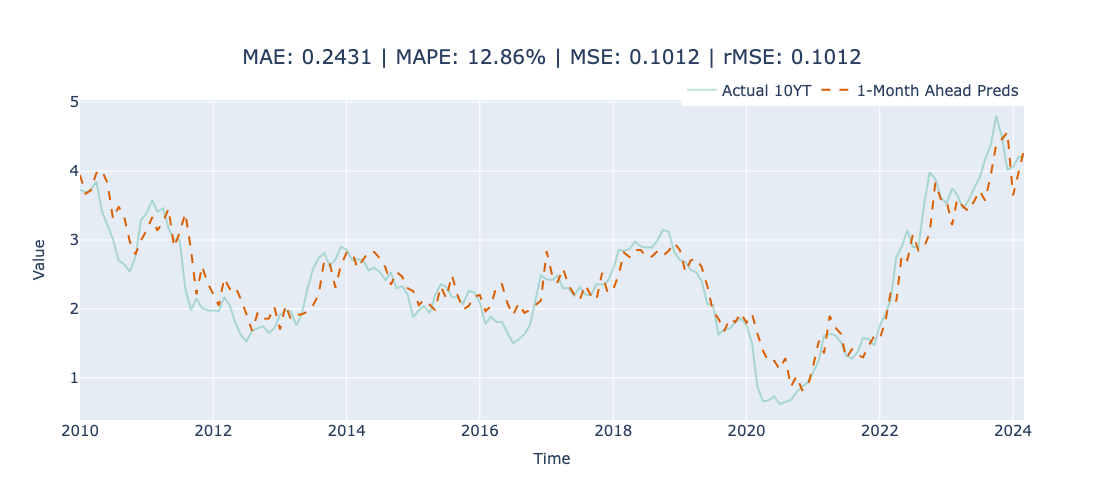

In [55]:
# create dataframe for plotting 
to_plot = pd.DataFrame(format_y_pred(step1_preds, "preds"))
to_plot = to_plot.join(format_y_pred(step1_act, "act"))

# plot results 
fig = plot_forecast(to_plot, forecast_columns=["preds"], forecast_display_names=['1-Month Ahead Preds'])
fig = format_plot(fig, title=f"MAE: {metrics['MAE']:.4f} | MAPE: {metrics['MAPE']:.2f}% | MSE: {metrics['MSE']:.4f} | rMSE: {metrics['rMSE']:.4f}")
fig.show()

## 6 Month Horizon

In [56]:
# forecast at each time step 
warnings.filterwarnings('ignore')
step1_preds_sc = xgb_model.historical_forecasts(series=train_targ_sc, past_covariates=train_past_cov_sc, forecast_horizon=6, stride=1, start=start)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [57]:
# unscale preds 
step1_preds = targ_scaler.inverse_transform(step1_preds_sc)

# get actuals for same time period 
step1_act = train_targ[step1_preds.time_index]

# store performance 
metrics = eval(step1_preds, step1_act, "6-month")
performance.append(metrics)

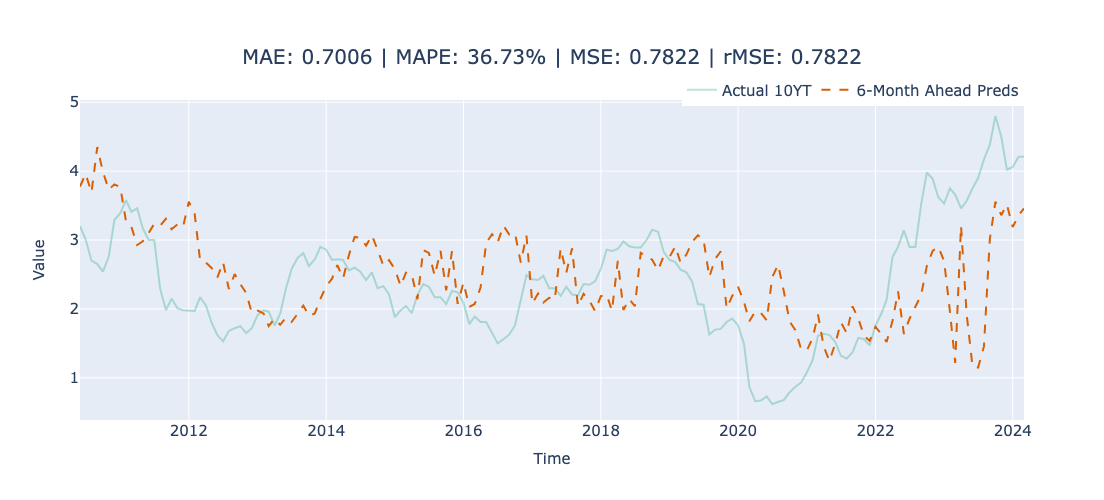

In [58]:
# create dataframe for plotting 
to_plot = pd.DataFrame(format_y_pred(step1_preds, "preds"))
to_plot = to_plot.join(format_y_pred(step1_act, "act"))

# plot results 
fig = plot_forecast(to_plot, forecast_columns=["preds"], forecast_display_names=['6-Month Ahead Preds'])
fig = format_plot(fig, title=f"MAE: {metrics['MAE']:.4f} | MAPE: {metrics['MAPE']:.2f}% | MSE: {metrics['MSE']:.4f} | rMSE: {metrics['rMSE']:.4f}")
fig.show()

## 12 Month Horizon

In [59]:
# forecast at each time step 
warnings.filterwarnings('ignore')
step1_preds_sc = xgb_model.historical_forecasts(series=train_targ_sc, past_covariates=train_past_cov_sc, forecast_horizon=12, stride=1, start=start)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [60]:
# unscale preds 
step1_preds = targ_scaler.inverse_transform(step1_preds_sc)

# get actuals for same time period 
step1_act = train_targ[step1_preds.time_index]

# store performance 
metrics = eval(step1_preds, step1_act, "12-month")
performance.append(metrics)

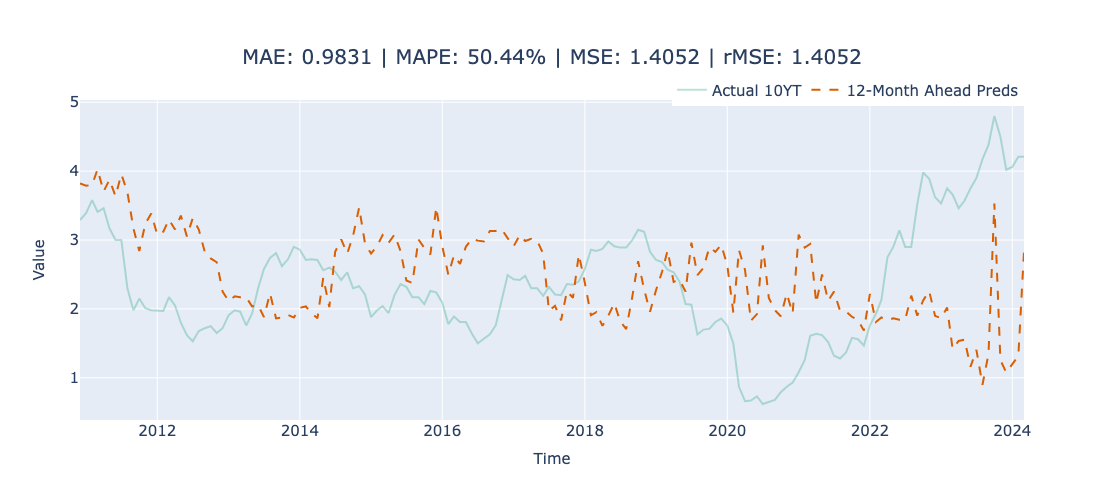

In [61]:
# create dataframe for plotting 
to_plot = pd.DataFrame(format_y_pred(step1_preds, "preds"))
to_plot = to_plot.join(format_y_pred(step1_act, "act"))

# plot results 
fig = plot_forecast(to_plot, forecast_columns=["preds"], forecast_display_names=['12-Month Ahead Preds'])
fig = format_plot(fig, title=f"MAE: {metrics['MAE']:.4f} | MAPE: {metrics['MAPE']:.2f}% | MSE: {metrics['MSE']:.4f} | rMSE: {metrics['rMSE']:.4f}")
fig.show()

# Results

In [62]:
performance = pd.DataFrame(performance)
performance.insert(0, 'Model', 'XGBoost + Macro Ind + Sentiments')

In [63]:
# Combine all performances into one table 
ar = pd.read_csv('../data/baselines/AR1_baseline_results.csv', encoding='utf-8')
xgb = pd.read_csv('../data/baselines/XGBoost_baseline_results.csv', encoding='utf-8')

ar.insert(0, 'Model', 'AR(1)')
xgb.insert(0, 'Model', 'XGBoost + Macro Ind')

final = pd.concat([ar, xgb, performance], axis=0)

In [64]:
final.pivot(index='Model', columns='Horizon', values='rMSE')

Horizon,1-month,12-month,6-month
Model,,,
AR(1),0.04,0.83,0.41
XGBoost + Macro Ind,0.08,1.13,0.51
XGBoost + Macro Ind + Sentiments,0.10,1.41,0.78


# Export Baseline Results to Table

In [ ]:
final.to_csv('../data/final_model_results.csv', encoding='utf-8', index=False)